# Importing Libraries and Configuring values

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from tqdm import tqdm
from scipy.linalg import sqrtm
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
import warnings
warnings.filterwarnings("ignore")

# Config
IMAGE_SIZE = 128
LATENT_DIM = 100
BATCH_SIZE = 64
EPOCHS = 100
DATA_DIR = "/kaggle/input/pokemon-images-dataset/pokemon_jpg/pokemon_jpg/"
SAVE_DIR = "/kaggle/working/generated_pokemon/"
os.makedirs(SAVE_DIR, exist_ok=True)

# Loading and processing images

In [2]:
def load_images(data_dir, image_size):
    image_paths = glob(os.path.join(data_dir, "*.jpg"))
    print(f"🧾 Found {len(image_paths)} images.")
    images = []
    for path in tqdm(image_paths[:2000]):
        img = Image.open(path).convert("RGB").resize((image_size, image_size))
        img = np.asarray(img).astype(np.float32)
        img = (img - 127.5) / 127.5
        images.append(img)
    return np.array(images)

all_images = load_images(DATA_DIR, IMAGE_SIZE)

🧾 Found 819 images.


100%|██████████| 819/819 [00:06<00:00, 133.99it/s]


# Standard Model (Default tf 2.x model)

## Generator

In [3]:
def make_generator():
    model = tf.keras.Sequential([
        layers.Dense(16 * 16 * 256, input_dim=LATENT_DIM),
        layers.Reshape((16, 16, 256)),
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.Conv2DTranspose(128, 4, strides=2, padding='same'),  # 32x32
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.Conv2DTranspose(64, 4, strides=2, padding='same'),   # 64x64
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')  # 128x128
    ])
    return model

## Discriminator

In [4]:
def make_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, 4, strides=2, padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        layers.LeakyReLU(0.2),
        layers.Conv2D(128, 4, strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Custome Model( Upgraded from tf 1.x to tf 2.x)

## Adding Normalzation
to help with dropout

In [5]:
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon

    def call(self, inputs):
        mean, var = tf.nn.moments(inputs, [1, 2], keepdims=True)
        return (inputs - mean) / tf.sqrt(var + self.epsilon)

## Generator

In [6]:
def generator():
    inputs = tf.keras.Input(shape=(LATENT_DIM,))
    x = layers.Dense(8 * 8 * 1024)(inputs)
    x = layers.Reshape((8, 8, 1024))(x)
    x = layers.LeakyReLU()(x)

    for filters in [512, 256, 128, 64]:
        x = layers.Conv2DTranspose(filters, 5, strides=2, padding='same')(x)
        x = InstanceNormalization()(x)
        x = layers.LeakyReLU()(x)
        x = layers.Dropout(0.3)(x)

    x = layers.Conv2DTranspose(3, 5, strides=1, padding='same', activation='tanh')(x)
    return tf.keras.Model(inputs, x, name="custom_generator")

## Discriminator

In [7]:
def discriminator():
    inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = inputs

    for filters, strides in zip([64, 128, 256, 512, 1024], [2, 2, 2, 1, 2]):
        x = layers.Conv2D(filters, 5, strides=strides, padding='same')(x)
        x = layers.LeakyReLU()(x)
        x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model(inputs, x, name="custom_discriminator")

# Adding images inside training

In [8]:
def show_real_fake_pairs(generator, real_batch, epoch, model_name):
    noise = tf.random.normal([real_batch.shape[0], LATENT_DIM])
    fake_batch = generator(noise, training=False)

    fig, axs = plt.subplots(1, real_batch.shape[0], figsize=(real_batch.shape[0] * 2, 2))
    for i in range(real_batch.shape[0]):
        merged = np.concatenate([(real_batch[i] + 1)/2, (fake_batch[i] + 1)/2], axis=1)  # side by side
        axs[i].imshow(merged)
        axs[i].axis('off')
    plt.suptitle(f"{model_name} - Real vs Fake (Epoch {epoch})")
    plt.tight_layout()
    plt.show()

# Adding fid tracking and graphs for better understanding

In [9]:
def plot_fid_curve(fid_scores, model_name, start_epoch=10, interval=10):
    x_epochs = list(range(start_epoch, start_epoch + len(fid_scores)*interval, interval))

    plt.figure(figsize=(10, 5))
    plt.plot(x_epochs, fid_scores, marker='o')
    for i, fid in enumerate(fid_scores):
        plt.text(x_epochs[i], fid + 5, f"{fid:.1f}", ha='center', fontsize=8)
    plt.title(f"FID Over Epochs - {model_name}")
    plt.xlabel("Epoch")
    plt.ylabel("FID Score")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Traning Function( customized to work for both the models)

In [10]:
def train_dcgan(generator, discriminator, images, model_name):
    model_dir = os.path.join(SAVE_DIR, model_name)
    os.makedirs(model_dir, exist_ok=True)

    cross_entropy = tf.keras.losses.BinaryCrossentropy()
    gen_opt = tf.keras.optimizers.Adam(1e-4)
    disc_opt = tf.keras.optimizers.Adam(1e-4)
    dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(1000).batch(BATCH_SIZE)

    fid_scores = []
    fixed_real_batch = images[:5]  # same 5 real samples across all epochs

    @tf.function
    def train_step(real_images):
        noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            fake_images = generator(noise, training=True)
            real_output = discriminator(real_images, training=True)
            fake_output = discriminator(fake_images, training=True)
            gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
            disc_loss = cross_entropy(tf.ones_like(real_output), real_output) + \
                        cross_entropy(tf.zeros_like(fake_output), fake_output)
        gen_opt.apply_gradients(zip(gen_tape.gradient(gen_loss, generator.trainable_variables), generator.trainable_variables))
        disc_opt.apply_gradients(zip(disc_tape.gradient(disc_loss, discriminator.trainable_variables), discriminator.trainable_variables))
        return gen_loss, disc_loss

    def save_generated_images(generator, epoch):
        noise = tf.random.normal([16, LATENT_DIM])
        predictions = generator(noise, training=False)
        predictions = (predictions + 1) / 2.0
        fig = plt.figure(figsize=(8, 2))
        for i in range(16):
            plt.subplot(2, 8, i + 1)
            plt.imshow(predictions[i])
            plt.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(model_dir, f"epoch_{epoch:03d}.png"))
        plt.close()

    for epoch in range(1, EPOCHS + 1):
        for real_images in dataset:
            g_loss, d_loss = train_step(real_images)

        print(f"Epoch {epoch} - G: {g_loss:.4f} | D: {d_loss:.4f}")

        if epoch % 10 == 0:
            # Show real-fake horizontal comparison
            show_real_fake_pairs(generator, fixed_real_batch, epoch, model_name)

            # Save image grid
            save_generated_images(generator, epoch)

            # Generate fake images for FID
            fake_path = os.path.join(SAVE_DIR, f"fid_{model_name}")
            generate_fid_images(generator, fake_path, n_images=500)

            # Save real images only once
            real_path = os.path.join(SAVE_DIR, "fid_real")
            if epoch == 10 and not os.path.exists(real_path):
                os.makedirs(real_path, exist_ok=True)
                for i in range(500):
                    img = (images[i] + 1) * 127.5
                    Image.fromarray(img.astype(np.uint8)).save(f"{real_path}/{i:04d}.png")

            # FID calculation
            fid = calculate_fid(real_path, fake_path)
            fid_scores.append(fid)
            print(f"🔥 FID at Epoch {epoch}: {fid:.2f}")

    # Plot FID curve at end of training
    plot_fid_curve(fid_scores, model_name, start_epoch=10)

# Check the FID Score

> Fréchet Inception Distance (FID)

* It is used to evaluate the quality of images generated by generative models
* It measures the distance between the distributions of features extracted from real and generated images using the Inception network (a pre-trained convolutional neural network).

In [11]:
def generate_fid_images(generator, path, n_images=500):
    os.makedirs(path, exist_ok=True)
    for i in range(n_images):
        noise = tf.random.normal([1, LATENT_DIM])
        fake = generator(noise, training=False)
        fake = (fake + 1) / 2.0
        img = (fake[0].numpy() * 255).astype(np.uint8)
        Image.fromarray(img).save(os.path.join(path, f"{i:04d}.png"))

def load_fid_images(path):
    paths = glob(os.path.join(path, "*.png"))
    imgs = []
    for p in paths:
        img = Image.open(p).convert("RGB").resize((299, 299))
        imgs.append(np.asarray(img).astype(np.float32))
    return preprocess_input(np.array(imgs))

def calculate_fid(real_path, fake_path):
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
    act1 = model.predict(load_fid_images(real_path), verbose=0)
    act2 = model.predict(load_fid_images(fake_path), verbose=0)
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2) ** 2)
    covmean = sqrtm(sigma1 @ sigma2)
    if np.iscomplexobj(covmean): covmean = covmean.real
    return ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

# Real-vs-Fake Classifier

In [12]:
def load_classifier_data(generator, n=1000, augment_real=True, label_smoothing=True):
    # Load and (optionally) augment real images
    X_real = all_images[:n]
    if augment_real:
        X_real_aug = []
        for img in X_real:
            try:
                aug_img = tf.image.random_flip_left_right(img).numpy()
                X_real_aug.append(aug_img)
            except:
                continue
        X_real = np.array(X_real_aug)
    
    # Adjust label length if real was trimmed
    n_real = len(X_real)
    y_real = np.ones((n_real,))
    if label_smoothing:
        y_real *= 0.9

    # Generate exactly n_real fake samples
    X_fake = []
    while len(X_fake) < n_real:
        noise = tf.random.normal([1, LATENT_DIM])
        img = generator(noise, training=False)[0].numpy()
        if img.shape == X_real[0].shape:
            X_fake.append(img)
    X_fake = np.array(X_fake)
    y_fake = np.zeros((n_real,))
    if label_smoothing:
        y_fake += 0.1

    # Combine
    X = np.concatenate([X_real, X_fake])
    y = np.concatenate([y_real, y_fake])

    print(f"✅ Final shape: X={X.shape}, y={y.shape}")
    return train_test_split(X, y, test_size=0.2, random_state=42)


def build_classifier():
    model = tf.keras.Sequential([
        layers.Conv2D(64, 4, strides=2, padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        layers.LeakyReLU(),
        layers.Conv2D(128, 4, strides=2, padding='same'),
        layers.LeakyReLU(),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Visualizing the Comparisons

In [13]:
def show_comparison(real_imgs, fake_std, fake_custom, n=5):
    fig, axs = plt.subplots(3, n, figsize=(n * 2, 6))
    for i in range(n):
        axs[0, i].imshow((real_imgs[i] + 1) / 2)
        axs[0, i].set_title("Real")
        axs[1, i].imshow((fake_std[i] + 1) / 2)
        axs[1, i].set_title("Standard")
        axs[2, i].imshow((fake_custom[i] + 1) / 2)
        axs[2, i].set_title("Custom")
        for j in range(3):
            axs[j, i].axis('off')
    plt.tight_layout()
    plt.show()

# Final Control block

## Standard Model

Epoch 1 - G: 2.2998 | D: 0.1276
Epoch 2 - G: 2.9335 | D: 0.0589
Epoch 3 - G: 3.1718 | D: 0.0670
Epoch 4 - G: 4.1657 | D: 0.0467
Epoch 5 - G: 3.9543 | D: 0.0941
Epoch 6 - G: 4.4351 | D: 0.0194
Epoch 7 - G: 4.7884 | D: 0.0263
Epoch 8 - G: 3.9996 | D: 0.0285
Epoch 9 - G: 5.0000 | D: 0.0121
Epoch 10 - G: 3.3199 | D: 0.0593


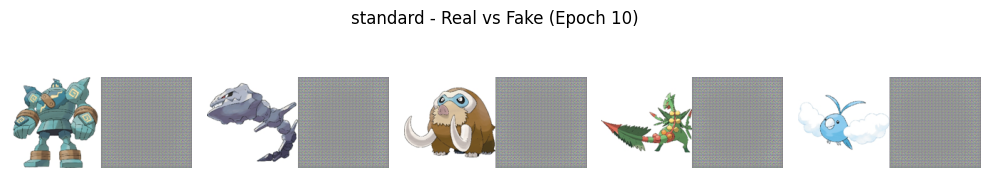

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
🔥 FID at Epoch 10: 407.24
Epoch 11 - G: 2.6476 | D: 0.1004
Epoch 12 - G: 2.1269 | D: 0.1746
Epoch 13 - G: 2.3902 | D: 0.1699
Epoch 14 - G: 1.9975 | D: 0.1778
Epoch 15 - G: 3.4279 | D: 0.1413
Epoch 16 - G: 1.3257 | D: 1.1520
Epoch 17 - G: 3.2869 | D: 0.1341
Epoch 18 - G: 2.9231 | D: 0.2092
Epoch 19 - G: 2.7215 | D: 0.1385
Epoch 20 - G: 3.3435 | D: 0.1497


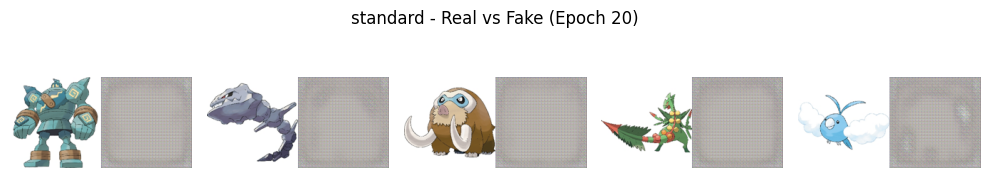

🔥 FID at Epoch 20: 425.81
Epoch 21 - G: 3.2925 | D: 0.1353
Epoch 22 - G: 4.1091 | D: 0.1061
Epoch 23 - G: 4.3885 | D: 0.0601
Epoch 24 - G: 2.9950 | D: 0.3086
Epoch 25 - G: 3.8814 | D: 0.1605
Epoch 26 - G: 3.6099 | D: 0.1051
Epoch 27 - G: 4.5721 | D: 0.1366
Epoch 28 - G: 3.8493 | D: 0.3024
Epoch 29 - G: 3.1905 | D: 0.4045
Epoch 30 - G: 7.2442 | D: 0.2078


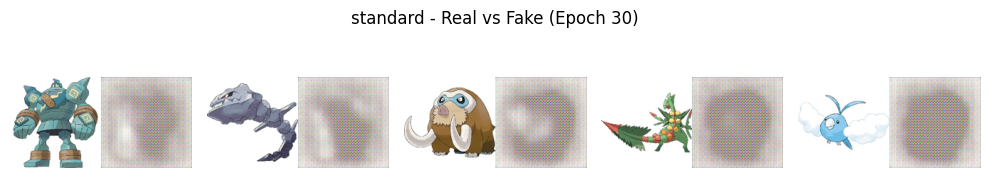

🔥 FID at Epoch 30: 352.32
Epoch 31 - G: 4.5081 | D: 0.3123
Epoch 32 - G: 6.3214 | D: 0.3284
Epoch 33 - G: 4.9511 | D: 0.1116
Epoch 34 - G: 4.9606 | D: 0.2811
Epoch 35 - G: 5.6997 | D: 0.1525
Epoch 36 - G: 3.6999 | D: 0.3266
Epoch 37 - G: 3.5963 | D: 0.3640
Epoch 38 - G: 2.9121 | D: 0.6652
Epoch 39 - G: 3.5220 | D: 0.9138
Epoch 40 - G: 3.1410 | D: 0.9630


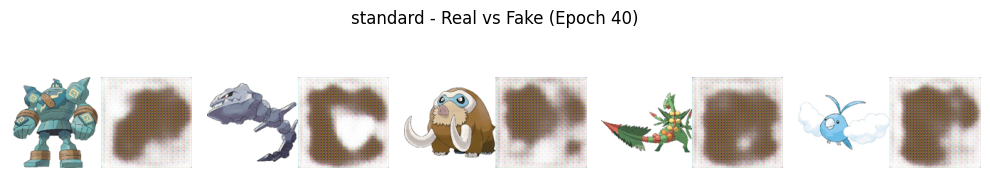

🔥 FID at Epoch 40: 374.12
Epoch 41 - G: 3.8392 | D: 0.3315
Epoch 42 - G: 3.6703 | D: 0.2120
Epoch 43 - G: 3.4137 | D: 0.3491
Epoch 44 - G: 3.6414 | D: 0.3372
Epoch 45 - G: 5.4202 | D: 0.2185
Epoch 46 - G: 3.9348 | D: 0.2796
Epoch 47 - G: 4.1729 | D: 0.3915
Epoch 48 - G: 3.9411 | D: 0.2866
Epoch 49 - G: 2.7194 | D: 0.4219
Epoch 50 - G: 3.8748 | D: 0.1340


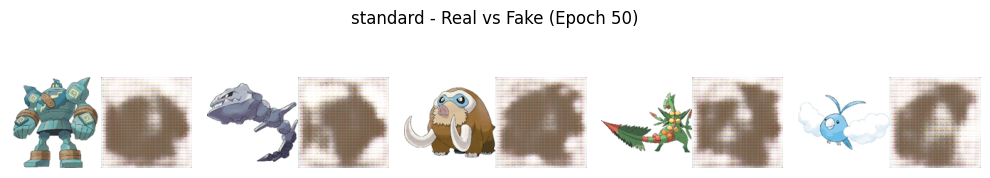

🔥 FID at Epoch 50: 367.77
Epoch 51 - G: 3.6812 | D: 0.0777
Epoch 52 - G: 3.2847 | D: 0.2861
Epoch 53 - G: 3.4126 | D: 0.2816
Epoch 54 - G: 2.2619 | D: 0.4017
Epoch 55 - G: 3.0488 | D: 0.3322
Epoch 56 - G: 2.6426 | D: 0.3240
Epoch 57 - G: 3.9033 | D: 0.4124
Epoch 58 - G: 4.6060 | D: 0.0948
Epoch 59 - G: 4.3952 | D: 0.3183
Epoch 60 - G: 3.4405 | D: 0.2029


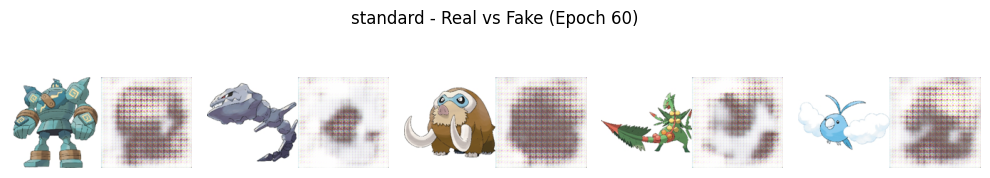

🔥 FID at Epoch 60: 397.74
Epoch 61 - G: 3.4399 | D: 0.2621
Epoch 62 - G: 4.6829 | D: 0.2599
Epoch 63 - G: 3.1621 | D: 0.1331
Epoch 64 - G: 2.9334 | D: 0.1967
Epoch 65 - G: 2.0291 | D: 0.5130
Epoch 66 - G: 1.7717 | D: 0.5783
Epoch 67 - G: 2.5797 | D: 0.5804
Epoch 68 - G: 3.0706 | D: 0.5154
Epoch 69 - G: 4.2842 | D: 0.1959
Epoch 70 - G: 3.9924 | D: 0.2518


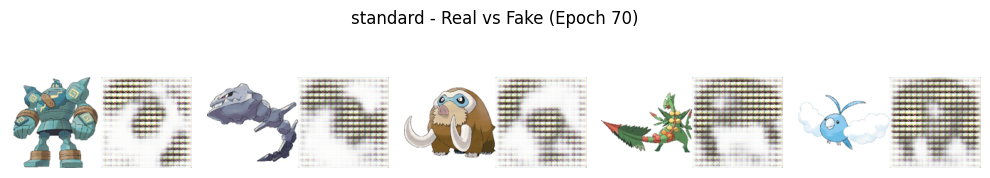

🔥 FID at Epoch 70: 322.25
Epoch 71 - G: 3.0041 | D: 0.3060
Epoch 72 - G: 2.4551 | D: 0.3813
Epoch 73 - G: 4.6187 | D: 0.2365
Epoch 74 - G: 2.4144 | D: 0.4461
Epoch 75 - G: 3.9853 | D: 0.5728
Epoch 76 - G: 1.4970 | D: 0.6916
Epoch 77 - G: 3.0001 | D: 0.5846
Epoch 78 - G: 1.5990 | D: 1.1949
Epoch 79 - G: 2.0009 | D: 1.2507
Epoch 80 - G: 2.4911 | D: 0.7446


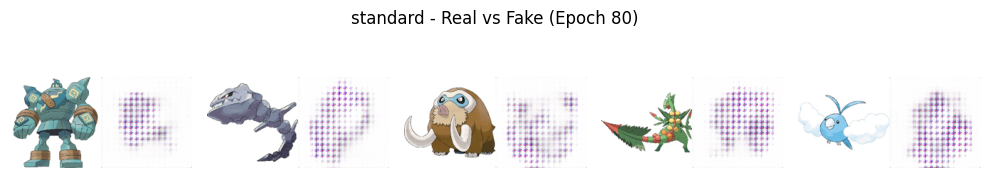

🔥 FID at Epoch 80: 371.55
Epoch 81 - G: 0.9892 | D: 0.6337
Epoch 82 - G: 3.8767 | D: 0.2818
Epoch 83 - G: 3.2104 | D: 0.2853
Epoch 84 - G: 2.5743 | D: 0.5804
Epoch 85 - G: 1.6351 | D: 1.4542
Epoch 86 - G: 3.6655 | D: 0.7828
Epoch 87 - G: 2.2196 | D: 0.5547
Epoch 88 - G: 3.6367 | D: 0.3490
Epoch 89 - G: 4.1470 | D: 0.3440
Epoch 90 - G: 3.3893 | D: 0.4912


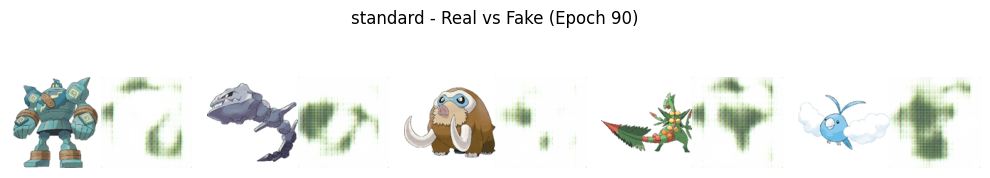

🔥 FID at Epoch 90: 344.22
Epoch 91 - G: 2.8846 | D: 0.5197
Epoch 92 - G: 3.5955 | D: 0.1376
Epoch 93 - G: 3.3593 | D: 0.3618
Epoch 94 - G: 1.3149 | D: 1.2294
Epoch 95 - G: 1.5472 | D: 1.1182
Epoch 96 - G: 4.1045 | D: 0.6104
Epoch 97 - G: 3.5048 | D: 0.3319
Epoch 98 - G: 3.1646 | D: 0.3454
Epoch 99 - G: 2.0159 | D: 0.9371
Epoch 100 - G: 1.2963 | D: 2.1793


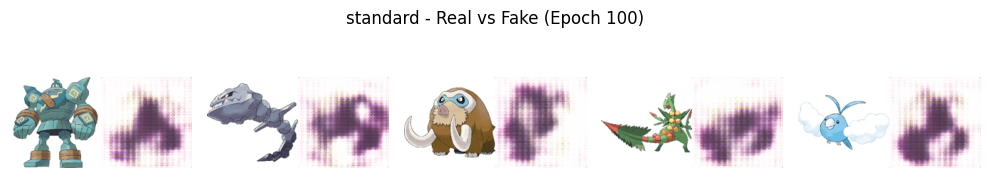

🔥 FID at Epoch 100: 354.28


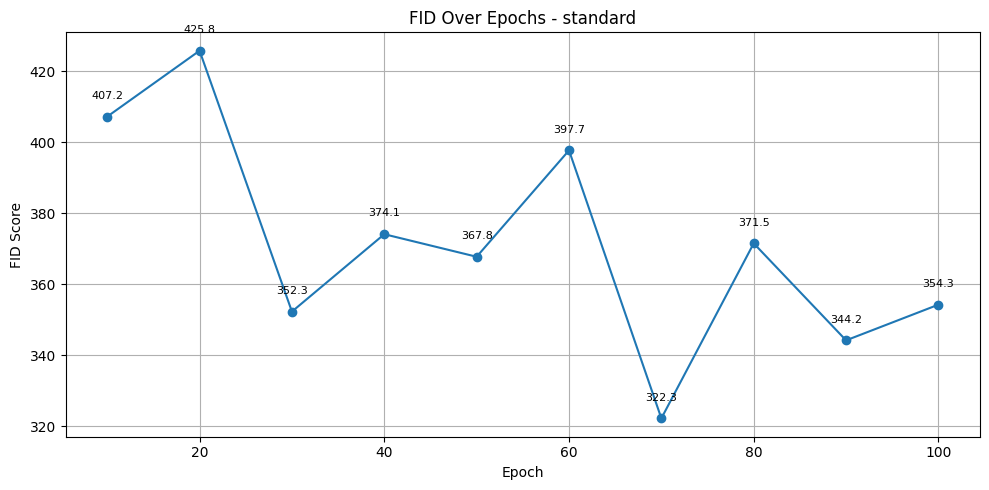

In [14]:
std_gen = make_generator()
std_disc = make_discriminator()
train_dcgan(std_gen, std_disc, all_images, "standard")

## Custom Model

Epoch 1 - G: 18.4176 | D: 0.0003
Epoch 2 - G: 21.7866 | D: 0.0058
Epoch 3 - G: 14.6101 | D: 0.0000
Epoch 4 - G: 7.2205 | D: 0.0009
Epoch 5 - G: 16.1517 | D: 0.0413
Epoch 6 - G: 7.5899 | D: 0.0098
Epoch 7 - G: 4.8349 | D: 0.0109
Epoch 8 - G: 12.2565 | D: 0.2415
Epoch 9 - G: 8.3457 | D: 0.0004
Epoch 10 - G: 8.0690 | D: 0.0004


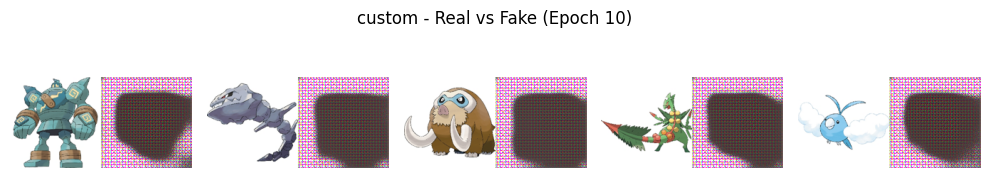

🔥 FID at Epoch 10: 412.03
Epoch 11 - G: 3.6576 | D: 0.0388
Epoch 12 - G: 12.8483 | D: 0.1056
Epoch 13 - G: 23.3468 | D: 0.0014
Epoch 14 - G: 12.7584 | D: 0.0008
Epoch 15 - G: 4.7342 | D: 0.6636
Epoch 16 - G: 5.9754 | D: 0.1262
Epoch 17 - G: 7.0230 | D: 0.0337
Epoch 18 - G: 5.5556 | D: 0.0853
Epoch 19 - G: 10.9724 | D: 0.1159
Epoch 20 - G: 8.3764 | D: 0.0328


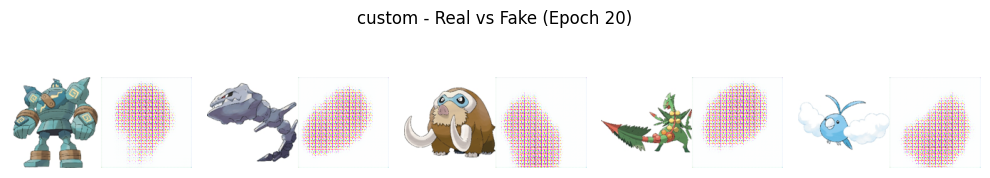

🔥 FID at Epoch 20: 346.71
Epoch 21 - G: 8.1157 | D: 0.0525
Epoch 22 - G: 18.2372 | D: 0.1109
Epoch 23 - G: 8.4215 | D: 0.6747
Epoch 24 - G: 34.5803 | D: 0.7984
Epoch 25 - G: 33.2909 | D: 0.1181
Epoch 26 - G: 80.4612 | D: 0.1141
Epoch 27 - G: 18.9194 | D: 0.0169
Epoch 28 - G: 6.7909 | D: 0.2629
Epoch 29 - G: 8.4770 | D: 0.0908
Epoch 30 - G: 12.7300 | D: 0.0005


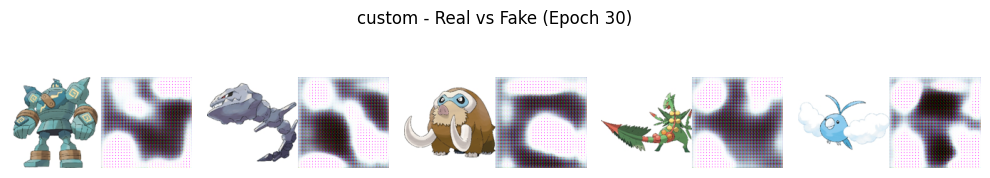

🔥 FID at Epoch 30: 411.83
Epoch 31 - G: 7.1061 | D: 0.0746
Epoch 32 - G: 17.8880 | D: 0.1256
Epoch 33 - G: 16.6522 | D: 0.1639
Epoch 34 - G: 2.9810 | D: 0.4424
Epoch 35 - G: 8.5136 | D: 0.1525
Epoch 36 - G: 2.5351 | D: 0.2522
Epoch 37 - G: 7.8528 | D: 0.1568
Epoch 38 - G: 5.9512 | D: 0.0387
Epoch 39 - G: 7.1154 | D: 0.0175
Epoch 40 - G: 6.3582 | D: 0.2512


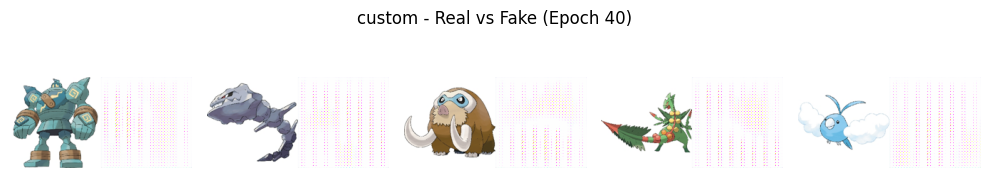

🔥 FID at Epoch 40: 393.43
Epoch 41 - G: 5.6487 | D: 0.0729
Epoch 42 - G: 6.7167 | D: 0.1314
Epoch 43 - G: 6.7544 | D: 0.0085
Epoch 44 - G: 4.9138 | D: 0.1187
Epoch 45 - G: 8.2452 | D: 0.0111
Epoch 46 - G: 7.3682 | D: 0.0153
Epoch 47 - G: 4.0997 | D: 0.0586
Epoch 48 - G: 4.5701 | D: 0.1112
Epoch 49 - G: 1.9493 | D: 0.3586
Epoch 50 - G: 4.7862 | D: 0.0580


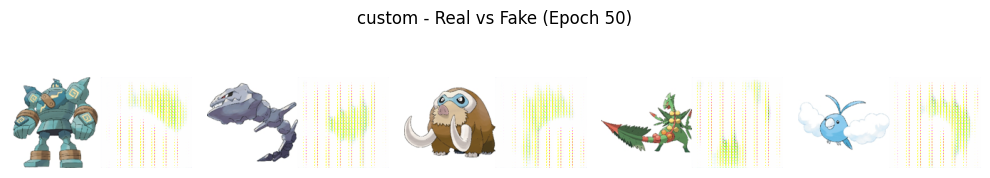

🔥 FID at Epoch 50: 336.75
Epoch 51 - G: 4.1258 | D: 0.0866
Epoch 52 - G: 6.5906 | D: 0.1547
Epoch 53 - G: 5.6147 | D: 0.0274
Epoch 54 - G: 9.5242 | D: 0.6459
Epoch 55 - G: 16.7523 | D: 1.9126
Epoch 56 - G: 14.7068 | D: 0.0131
Epoch 57 - G: 7.9315 | D: 0.0495
Epoch 58 - G: 7.9525 | D: 0.0147
Epoch 59 - G: 5.6530 | D: 0.1280
Epoch 60 - G: 4.2859 | D: 0.1405


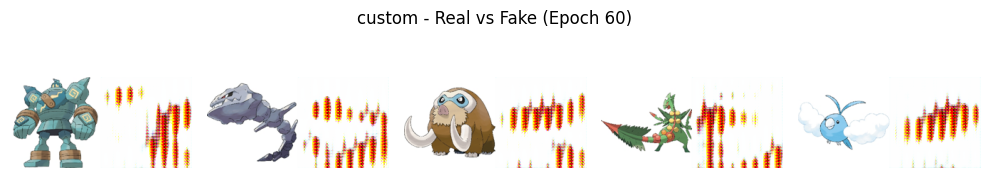

🔥 FID at Epoch 60: 333.58
Epoch 61 - G: 6.8284 | D: 0.0600
Epoch 62 - G: 8.3944 | D: 0.0335
Epoch 63 - G: 9.7492 | D: 0.0032
Epoch 64 - G: 8.5394 | D: 0.0782
Epoch 65 - G: 3.0473 | D: 0.2354
Epoch 66 - G: 19.2016 | D: 1.0648
Epoch 67 - G: 20.2820 | D: 0.0747
Epoch 68 - G: 5.6093 | D: 0.0598
Epoch 69 - G: 10.6619 | D: 0.0146
Epoch 70 - G: 5.7785 | D: 0.0325


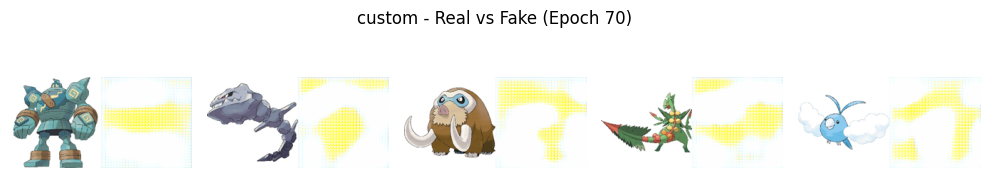

🔥 FID at Epoch 70: 412.43
Epoch 71 - G: 5.0884 | D: 0.2760
Epoch 72 - G: 5.1689 | D: 0.0195
Epoch 73 - G: 5.9574 | D: 0.0103
Epoch 74 - G: 6.7819 | D: 0.0830
Epoch 75 - G: 9.3811 | D: 0.0007
Epoch 76 - G: 6.5602 | D: 0.0040
Epoch 77 - G: 7.0322 | D: 0.0051
Epoch 78 - G: 6.7953 | D: 0.0029
Epoch 79 - G: 6.0095 | D: 0.0109
Epoch 80 - G: 6.8253 | D: 0.0857


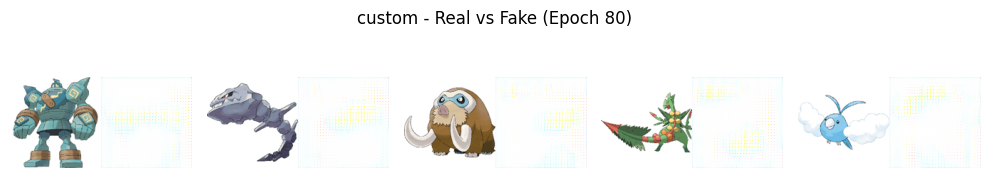

🔥 FID at Epoch 80: 331.14
Epoch 81 - G: 5.9736 | D: 0.0139
Epoch 82 - G: 5.2730 | D: 0.0188
Epoch 83 - G: 6.6560 | D: 0.0067
Epoch 84 - G: 6.2809 | D: 0.0154
Epoch 85 - G: 6.5549 | D: 0.5614
Epoch 86 - G: 10.3612 | D: 0.3153
Epoch 87 - G: 12.7278 | D: 0.3972
Epoch 88 - G: 4.7264 | D: 0.6990
Epoch 89 - G: 5.5998 | D: 0.4029
Epoch 90 - G: 5.3264 | D: 1.0408


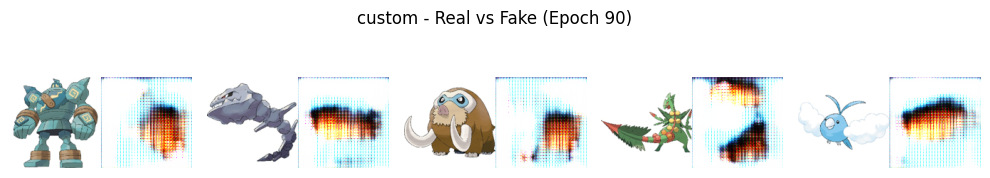

🔥 FID at Epoch 90: 278.32
Epoch 91 - G: 7.5659 | D: 0.1648
Epoch 92 - G: 5.1062 | D: 0.1074
Epoch 93 - G: 4.5869 | D: 0.0426
Epoch 94 - G: 10.0222 | D: 1.2585
Epoch 95 - G: 13.6578 | D: 0.5300
Epoch 96 - G: 6.5781 | D: 6.3403
Epoch 97 - G: 5.5998 | D: 0.0193
Epoch 98 - G: 6.0763 | D: 0.3447
Epoch 99 - G: 4.0291 | D: 0.3373
Epoch 100 - G: 5.2461 | D: 0.2093


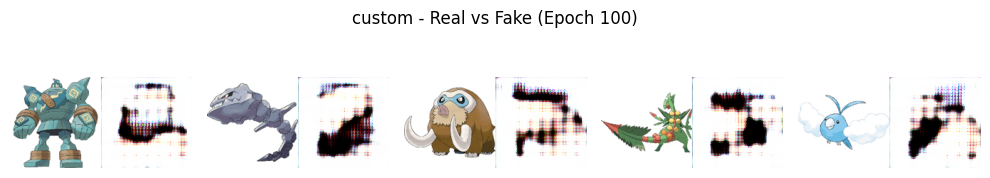

🔥 FID at Epoch 100: 309.03


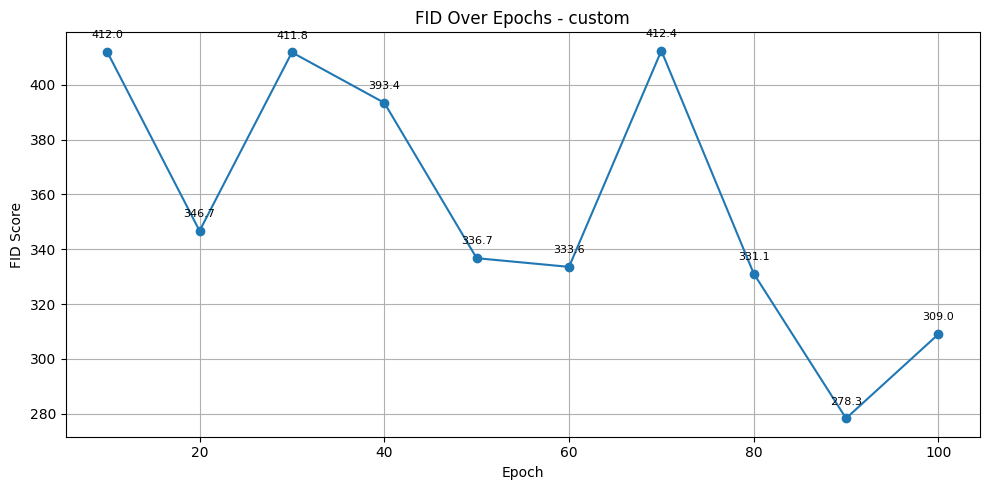

In [15]:
custom_gen = generator()
custom_disc = discriminator()
train_dcgan(custom_gen, custom_disc, all_images, "custom")

## Real and Fake images for FID
1. Saving the *Real images*
2. Saving the *Fake images*
3. Calculating FID

In [16]:
generate_fid_images(std_gen, os.path.join(SAVE_DIR, "fake_standard"))
generate_fid_images(custom_gen, os.path.join(SAVE_DIR, "fake_custom"))
fid_std = calculate_fid(os.path.join(SAVE_DIR, "fid_real"), os.path.join(SAVE_DIR, "fake_standard"))
fid_cus = calculate_fid(os.path.join(SAVE_DIR, "fid_real"), os.path.join(SAVE_DIR, "fake_custom"))

## Real vs Fake Classifier
1. Evaluation
2. Visual Comparison

✅ Final shape: X=(1638, 128, 128, 3), y=(1638,)
✅ Final shape: X=(1638, 128, 128, 3), y=(1638,)


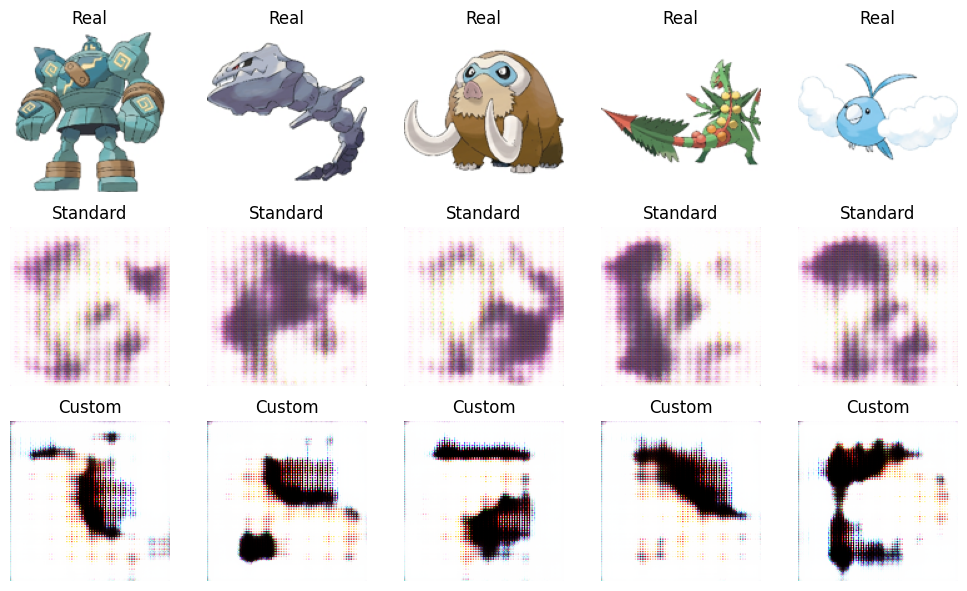

In [17]:
# Evaluation
Xr1, Xt1, yr1, yt1 = load_classifier_data(std_gen)
clf1 = build_classifier()
clf1.fit(Xr1, yr1, batch_size=64, epochs=5, verbose=0)
acc_std = clf1.evaluate(Xt1, yt1, verbose=0)[1]

Xr2, Xt2, yr2, yt2 = load_classifier_data(custom_gen)
clf2 = build_classifier()
clf2.fit(Xr2, yr2, batch_size=64, epochs=5, verbose=0)
acc_cus = clf2.evaluate(Xt2, yt2, verbose=0)[1]

# Visual Comparison Grid
sample_noise = tf.random.normal([5, LATENT_DIM])
real_imgs = all_images[:5]
fake_std = std_gen(sample_noise, training=False)
fake_cus = custom_gen(sample_noise, training=False)
show_comparison(real_imgs, fake_std, fake_cus)

# Final Result

In [18]:
print("Final Results:")
print(f"FID Score (Standard):   {fid_std:.2f}")
print(f"FID Score (Custom):     {fid_cus:.2f}")
print(f"Classifier Acc (Standard): {acc_std:.2%}")
print(f"Classifier Acc (Custom):   {acc_cus:.2%}")

Final Results:
FID Score (Standard):   357.08
FID Score (Custom):     307.05
Classifier Acc (Standard): 0.00%
Classifier Acc (Custom):   0.00%


In [19]:
def print_results_summary(
    fid_std, fid_cus,
    acc_std, acc_cus,
    std_label="Standard",
    custom_label="Custom"
):
    print("🏁 Final Battle of the GANs Summary\n" + "-"*45)
    print(f"{'Metric':<30}{std_label:<15}{custom_label}")
    print("-" * 60)
    print(f"{'FID Score':<30}{fid_std:<15.2f}{fid_cus:.2f}")
    print(f"{'Classifier Accuracy':<30}{acc_std:<15.2%}{acc_cus:.2%}")
    
    print("\n🧠 Interpretation:")
    if fid_std < fid_cus:
        print(f"📉 {std_label} GAN has lower FID (more realistic & diverse)")
    else:
        print(f"📉 {custom_label} GAN has lower FID (more realistic & diverse)")

    if acc_std < acc_cus:
        print(f"🎭 {std_label} GAN fooled the classifier more → better realism!")
    else:
        print(f"🎭 {custom_label} GAN fooled the classifier more → better realism!")

print_results_summary(
    fid_std=fid_std,
    fid_cus=fid_cus,
    acc_std=acc_std,
    acc_cus=acc_cus
)

🏁 Final Battle of the GANs Summary
---------------------------------------------
Metric                        Standard       Custom
------------------------------------------------------------
FID Score                     357.08         307.05
Classifier Accuracy           0.00%          0.00%

🧠 Interpretation:
📉 Custom GAN has lower FID (more realistic & diverse)
🎭 Custom GAN fooled the classifier more → better realism!
